In [189]:
from paper.sysproduction.update_historical_prices import update_historical_prices
from paper.topic.common_import import *
from sysquant.estimators.vol import simple_ewvol_calc
from scipy.stats import gmean

update_historical_prices()

def screen(look_back_days, vol_look_back_days, end=pd.Timestamp.now(), ins = 'BTC-USDT-Binance'):
    start = end - np.timedelta64(look_back_days + vol_look_back_days , "D")
    period = (start, end)
    fre = 'Hour'
    vol_look_back_hours = vol_look_back_days * 24

    '''Data'''
    history = artic_lib.read('{}/{}'.format(fre, ins)).data
    volume = select_period(history['VOLUME'], period)
    close = select_period(history['FINAL'].rename('close price'), period)
    print('mean={}, gmean={}, pct_chg={}'.format(close.mean(), gmean(close), close[-1] / close[0] - 1))

    '''Feature'''
    feature1 = close
    fig = feature1.plot(legend=True, figsize=(16, 4))
    plt.title('{}/{} {}'.format(fre, ins, (close.index[0], close.index[-1])))

    # feature2 = simple_ewvol_calc(close.pct_change(), days=vol_look_back_hours, min_periods=vol_look_back_hours).rename('vol') * np.sqrt(24) * np.sqrt(365)
    # feature2.plot(legend=True, figsize=(16, 4), secondary_y=True)

    feature3 = volume
    feature3.plot(legend=True, figsize=(16, 4), secondary_y=True, lw=0.5)
    plt.show()
    # volume.resample("M").sum().plot.bar(legend=True)
    # plt.show()

    plt.figure(figsize=(8,4))
    plt.title('Return Distribution')
    _ = sns.histplot(feature1.pct_change().rename('return'), log_scale=(False, True), binwidth=0.004)
    plt.show()
    # show(feature1.pct_change().sort_values())

mean=21301.06666666667, gmean=21292.48591219509, pct_chg=-0.07307944058780691


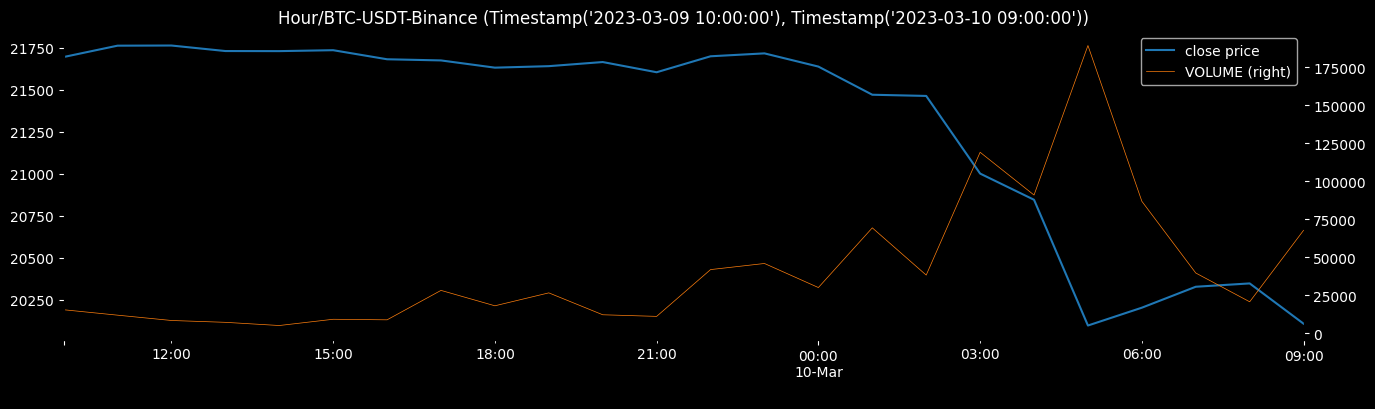

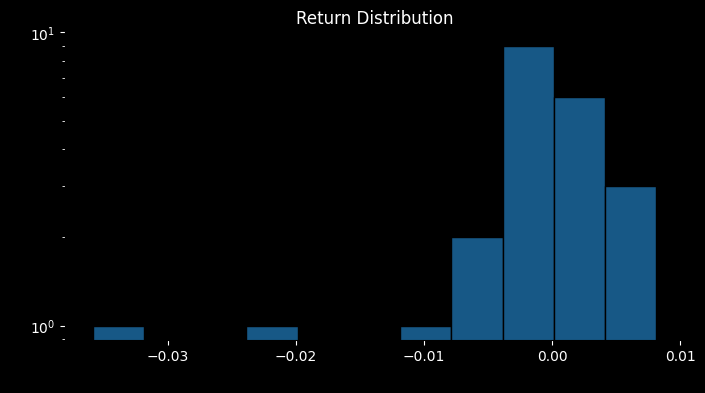

mean=22156.130952380947, gmean=22151.55253003421, pct_chg=-0.09164088085827216


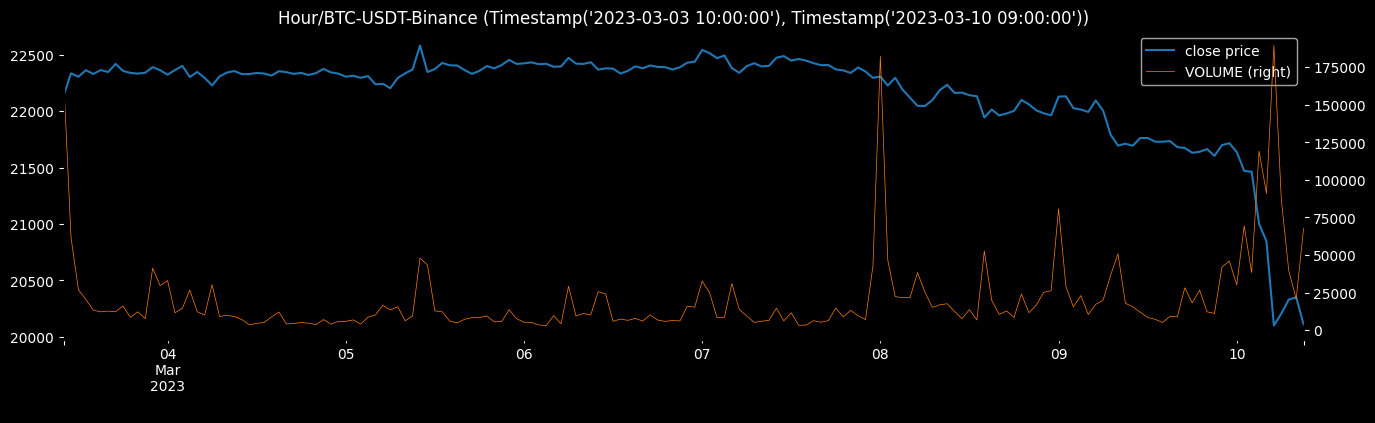

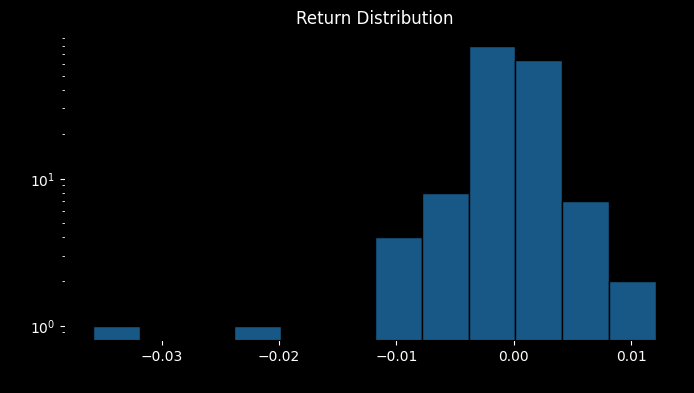

mean=23046.117222222227, gmean=23021.797421045383, pct_chg=-0.13621622086005536


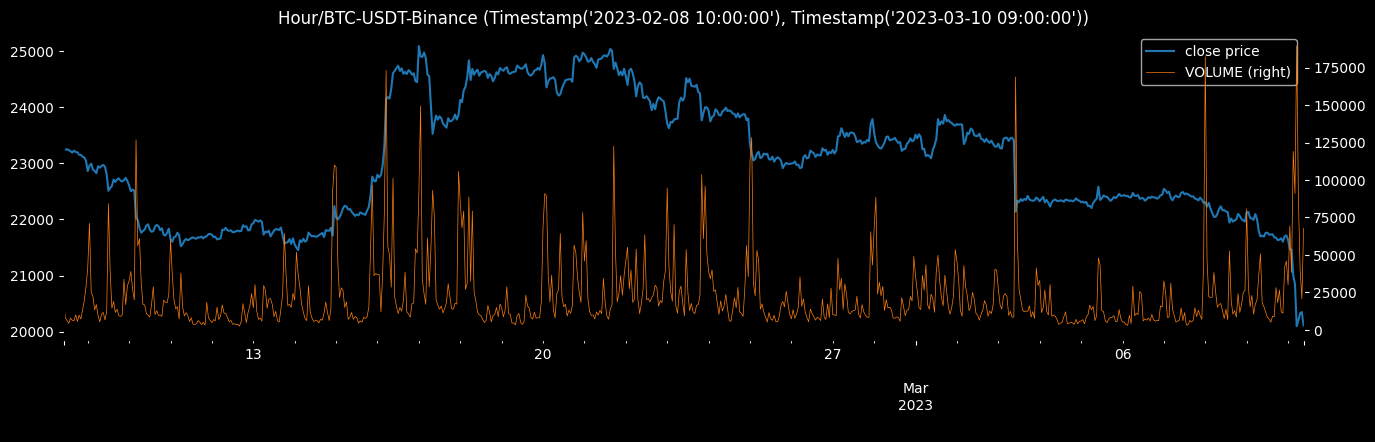

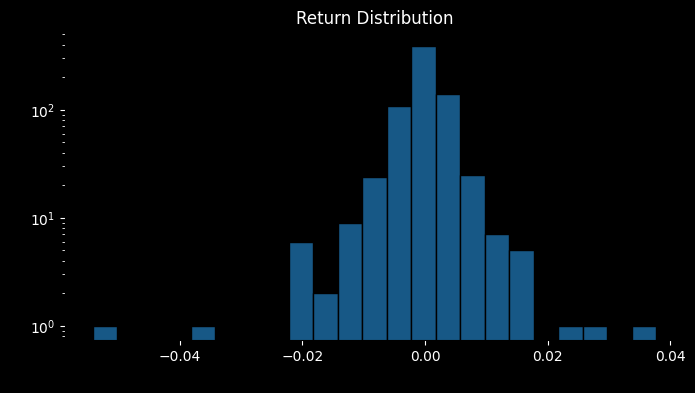

In [185]:
screen(look_back_days=1, vol_look_back_days=0)
screen(look_back_days=7, vol_look_back_days=0)
screen(look_back_days=30, vol_look_back_days=0)
# screen(look_back_days=60, vol_look_back_days=1)

mean=17285.2617626648, gmean=17240.151046080016, pct_chg=-0.18855180980980013


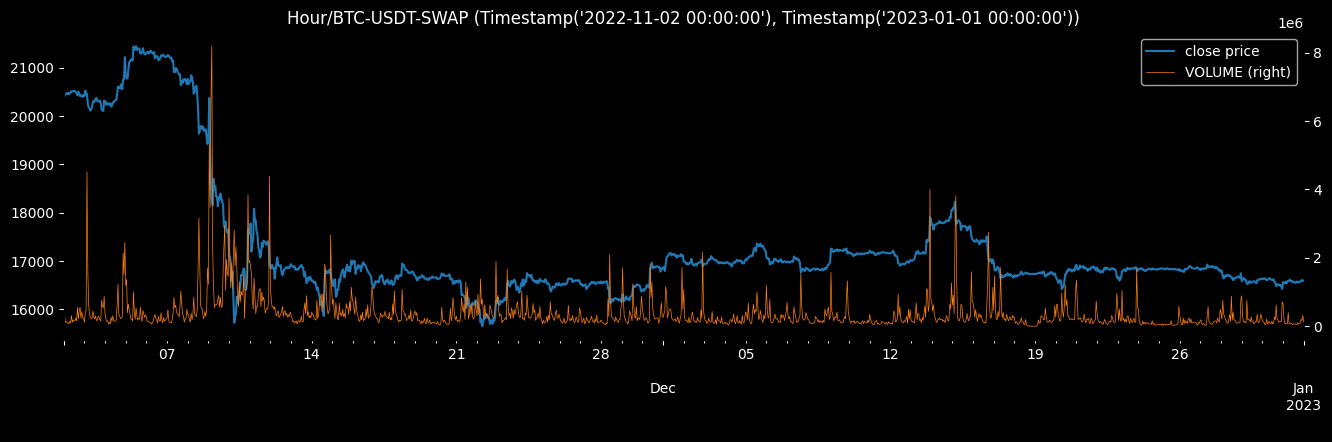

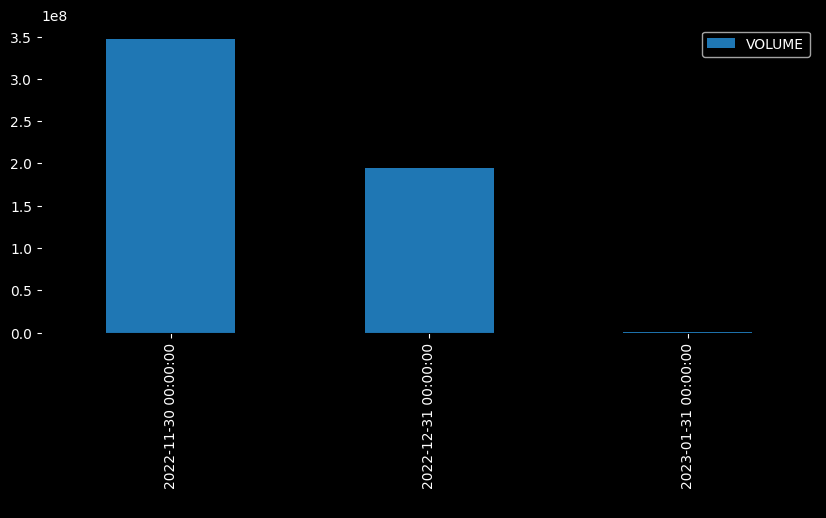

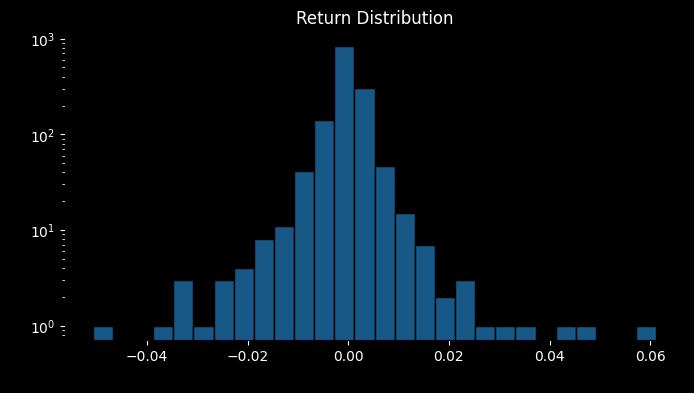

mean=19688.538694746516, gmean=19554.478919474015, pct_chg=-0.1620446361382013


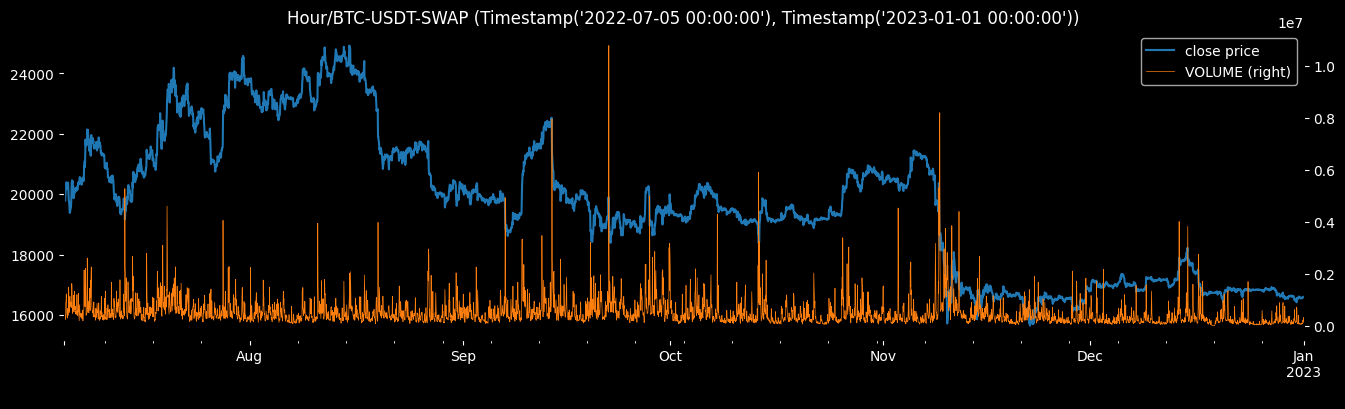

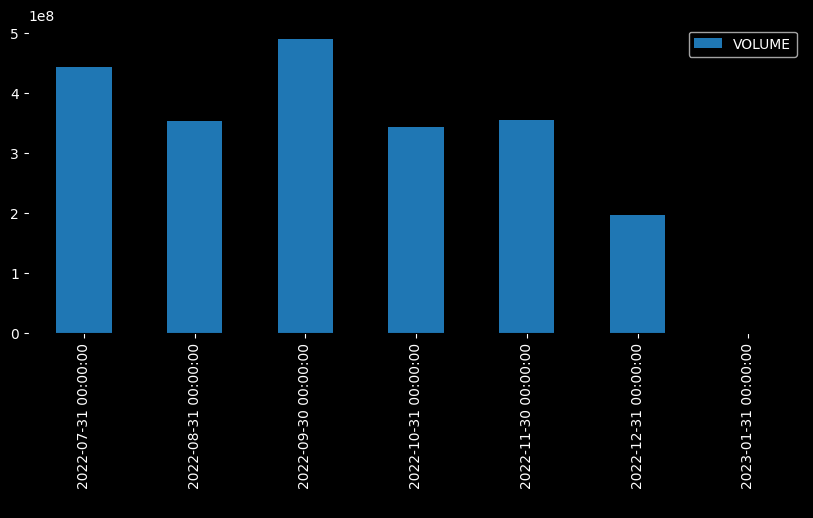

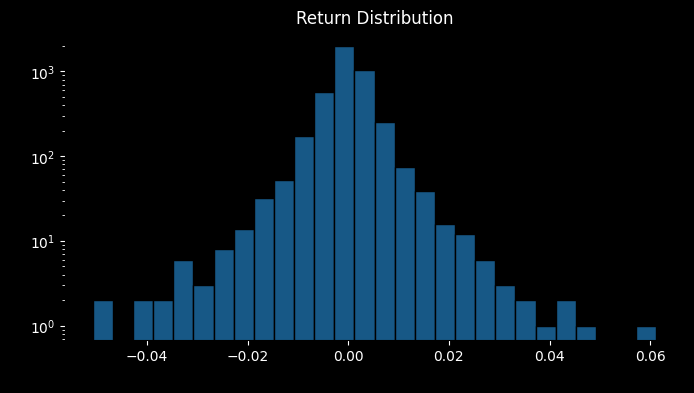

mean=27997.12982293715, gmean=26293.237543305822, pct_chg=-0.6441197478405793


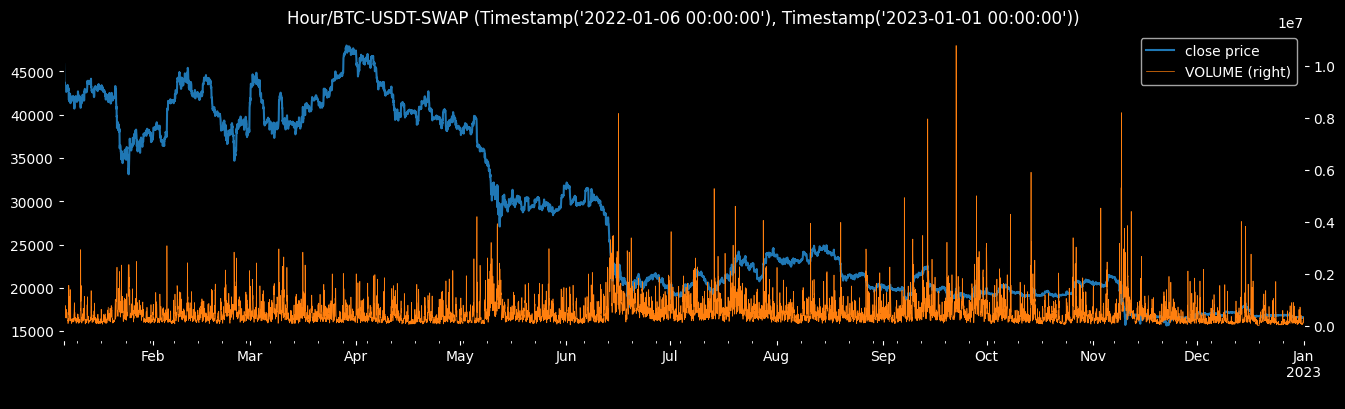

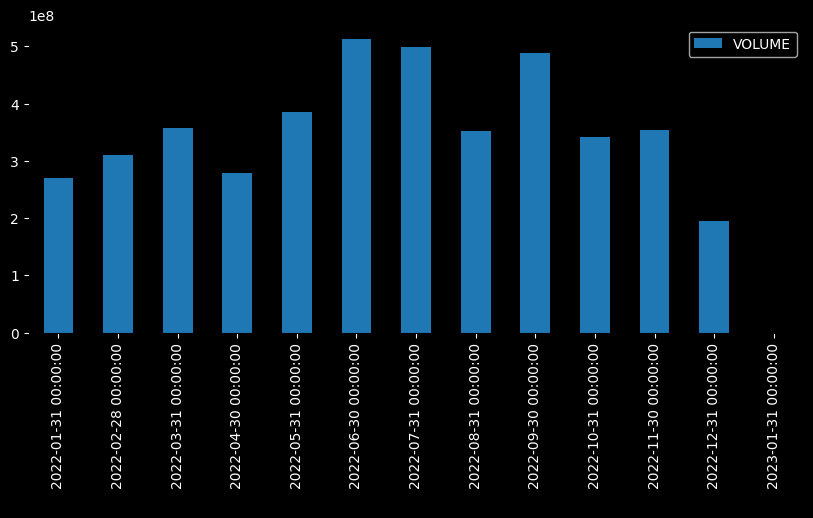

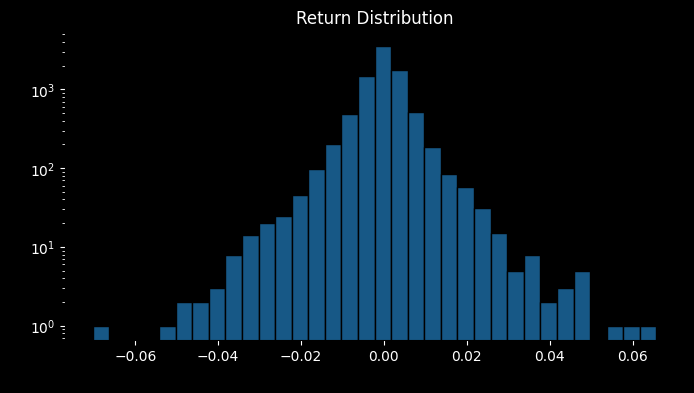

mean=33304.65304384053, gmean=29206.459467623314, pct_chg=0.799522776572668


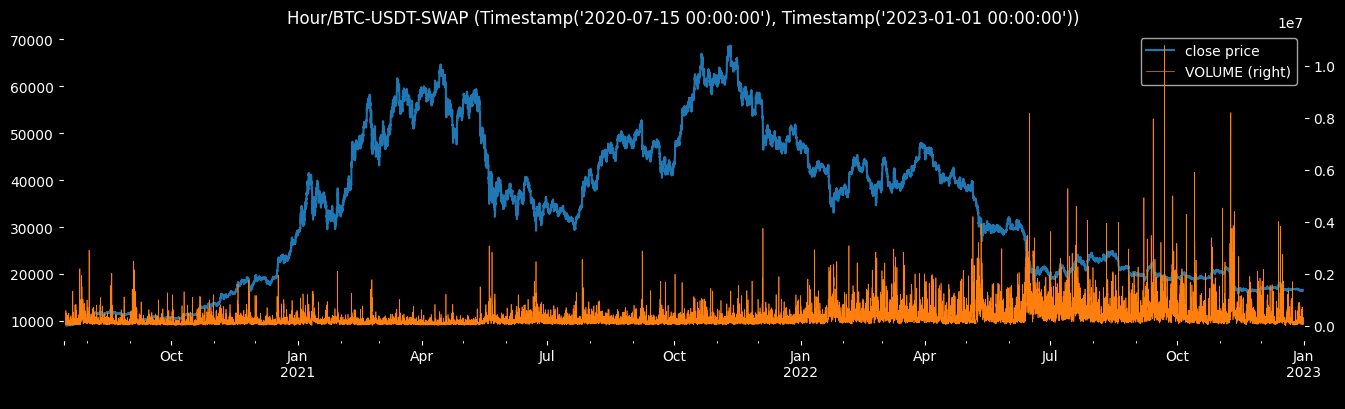

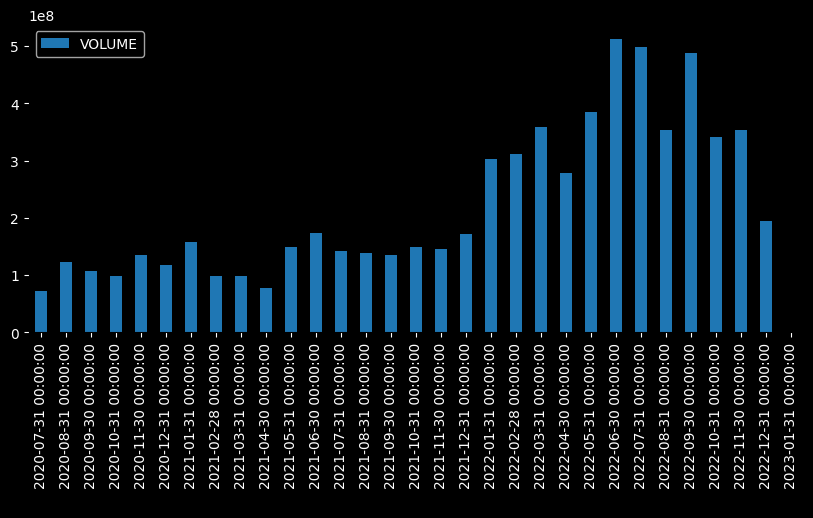

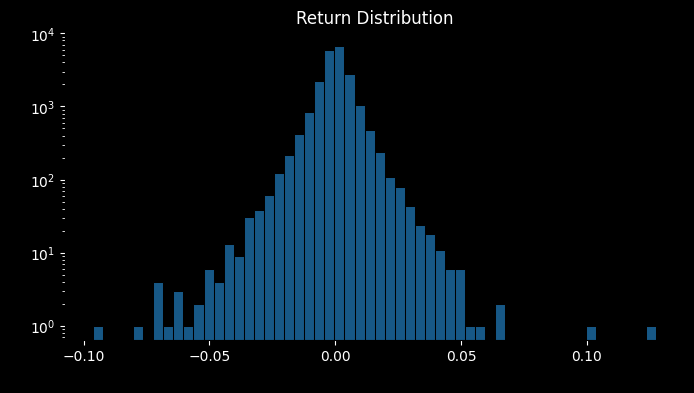

In [178]:
# screen(look_back_days=1, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=2, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=3, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))

screen(look_back_days=30 * 2, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
screen(look_back_days=30 * 6, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
screen(look_back_days=30 * 12, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
screen(look_back_days=30 * 30, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')

In [188]:
'''Charting'''
from systems.provided.rules.breakout import breakout

_close = close.tail(90 * 24)
_  = _close.plot(legend=True, figsize=(16, 4))
ax = breakout(_close, lookback=50 * 24).plot(legend=True, figsize=(16, 4), secondary_y=True)
ax.hlines(0, _close.index[0], _close.index[-1], colors='r', linestyles='dashed')

In [4]:
for ins in system.portfolio.get_instrument_list():
    pos = system.portfolio.get_actual_position(ins).rename(ins)
    show(pos)

1.162792410545483
1.9021959458812752
3348.117881368478
-777.5400318174273
-1760.1330129096223
0.9356223175965666


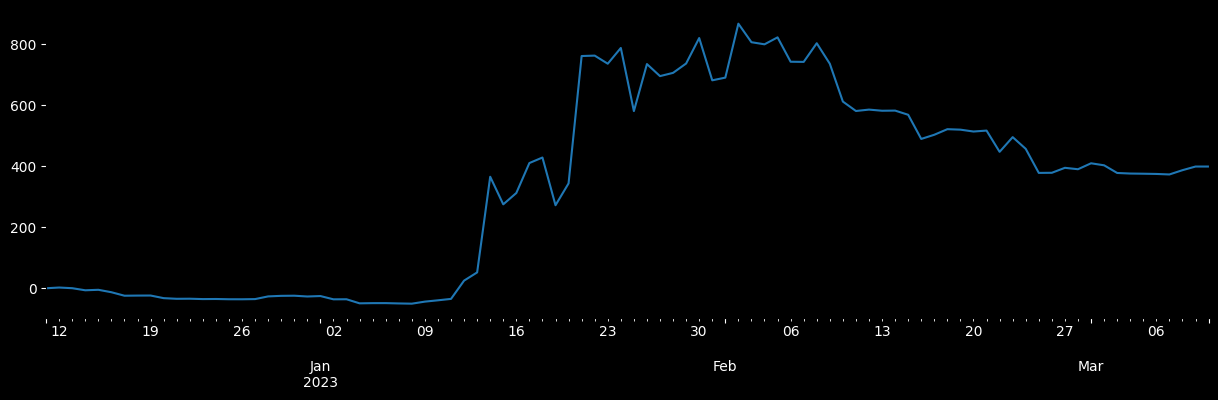

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


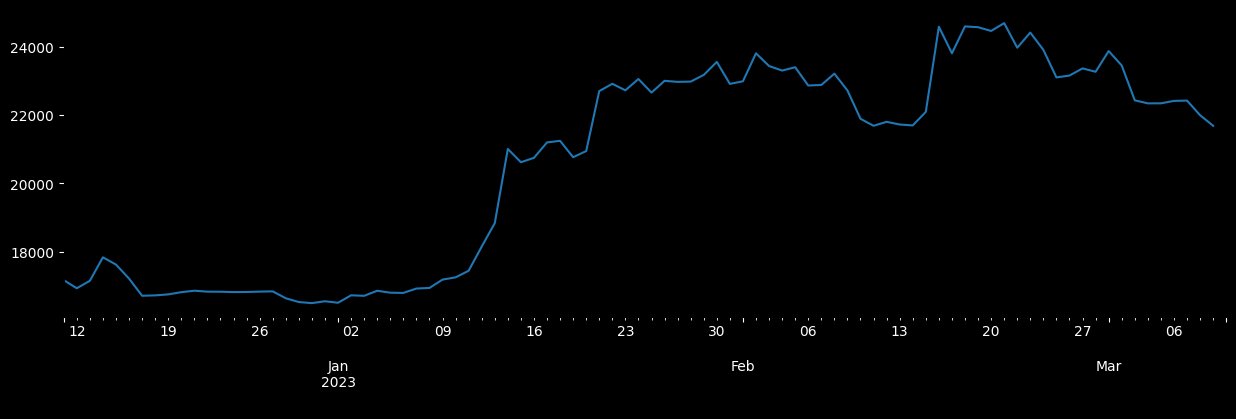

In [192]:
pl = system.accounts.portfolio()
print(pl.sharpe())
print(pl.calmar())
print(pl.ann_mean())
print(pl.avg_drawdown())
print(pl.worst_drawdown())
print(pl.time_in_drawdown())

# pct_pl = (pl / system.accounts.get_notional_capital()).rename('pct pl')
# pct_pl.plot(secondary_y=True, figsize=(15,4))
cum_pl = pl.tail(90).cumsum().rename('cum pl')
cum_pl.plot(figsize=(15,4))
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc.tail(90).plot(figsize=(15,4))
# print(system.accounts.portfolio().stats())
# show(system.portfolio.get_instrument_weights())
# print((1500+2500)/1500)
show(btc)

2023-02-03 14:07:01 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2023-02-03 14:07:01 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2023-02-03 14:07:01 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'accounts'}  Calculating pandl for portfolio
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'positionSize'}  Getting vol target
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating pandl for instrument for ADA-USDT-SWAP
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating notional position for ADA-USDT-SWAP
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2023-02-03 14:07:01 {'t

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating daily prices for ADA-USDT-SWAP
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating daily volatility for ADA-USDT-SWAP
2023-02-03 14:07:01 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating daily prices for ADA-USDT-SWAP
2023-02-03 14:07:02 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'ADA-USDT-SWAP'}  Calculating combined forecast for ADA-USDT-SWAP
2023-02-03 14:07:02 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'ADA-USDT-SWAP', 'rule_variation_name': 'ewmac4'}  Calculating capped forecast for ADA-USDT-SWAP ewmac4
2023-02-03 14:07:02 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'ADA-USDT-SWAP', 'rule_variation_name': 'ewmac4'}  Calculating raw forecast ADA-USDT-SWAP for ewmac4
2023-02-03 14:07:02 {'type': 'ba

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BNB-USDT'}  Calculating pandl for instrument for BNB-USDT
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BNB-USDT'}  Calculating notional position for BNB-USDT
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BNB-USDT'}  Calculating buffers for BNB-USDT
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BNB-USDT'}  Calculating forecast method buffers for BNB-USDT
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'accounts'}  Calculating buffered positions
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BNB-USDT'}  Calculating pandl for instrument for BNB-USDT
2023-02-03 14:07:09 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating pandl for instrument for BTC-USDT-SWAP
2023-02-03 14:07:09 {'type': 'base_system', '

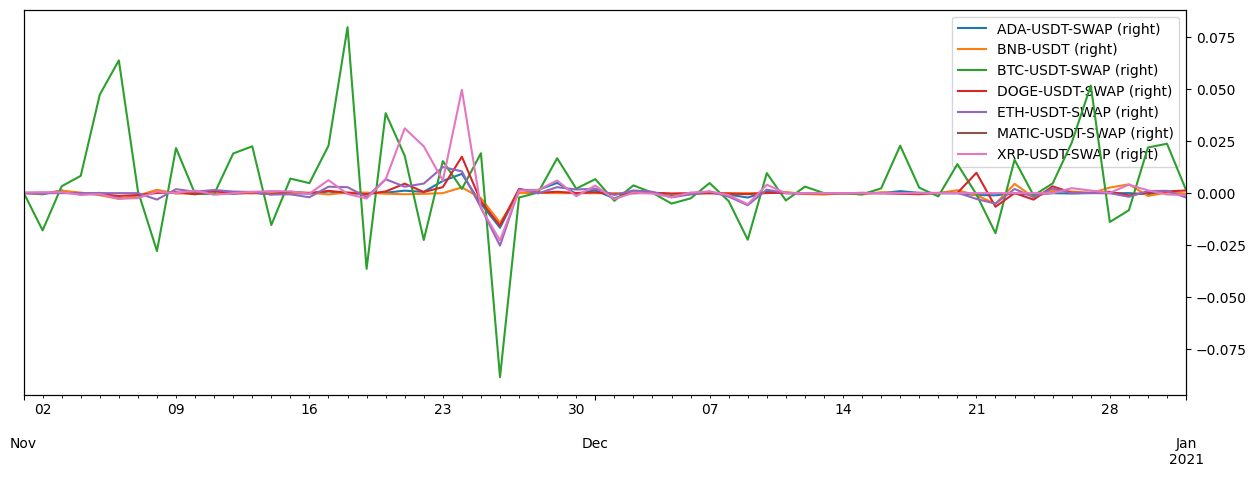

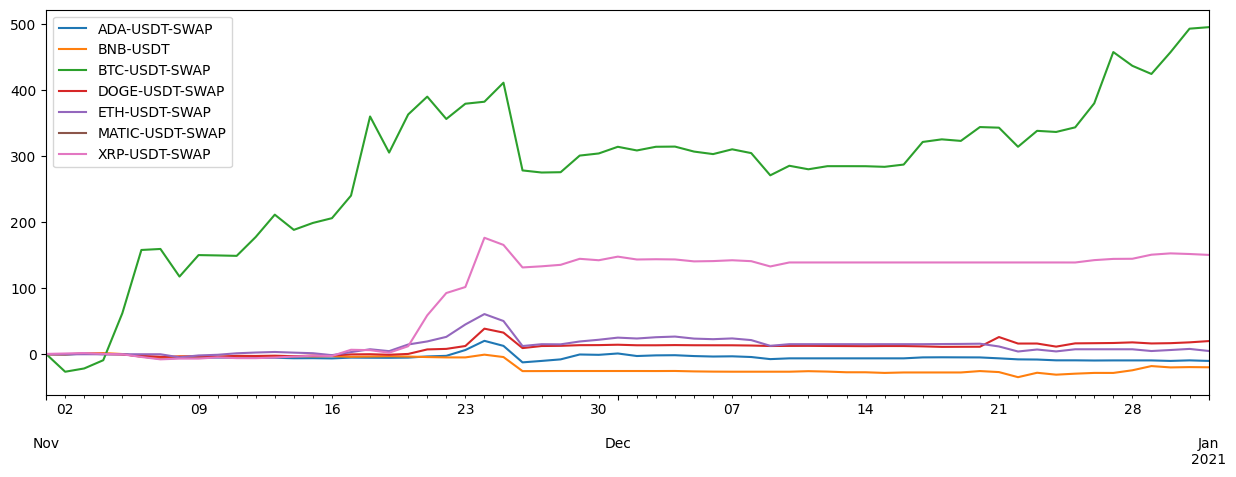

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


<AxesSubplot:>

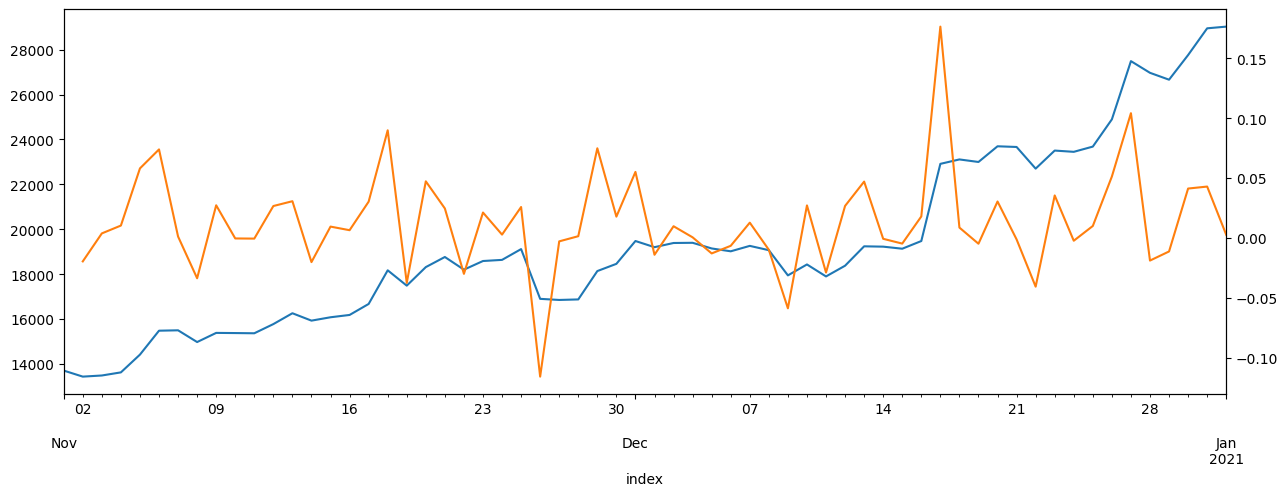

In [44]:
st = '2020-11-01'
et = '2021-01-01'

pl = system.accounts.portfolio().to_frame()
pl = select(pl, st, et)
pct_pl = (pl / system.accounts.get_notional_capital())
pct_pl.plot(secondary_y=True, figsize=(15,5))
cum_pl = pl.cumsum(axis=0)
cum_pl.plot(figsize=(15,5))
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,5))
btc.pct_change().plot(secondary_y=True)

2023-02-03 14:59:16 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2023-02-03 14:59:16 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2023-02-03 14:59:16 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating actual position for BTC-USDT-SWAP
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating notional position for BTC-USDT-SWAP
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'portfolio'}  Calculating raw instrument weights
2023-02-03 14:59:16 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'ba

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily volatility for BTC-USDT-SWAP
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily prices for BTC-USDT-SWAP
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating combined forecast for BTC-USDT-SWAP
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'ewmac4'}  Calculating capped forecast for BTC-USDT-SWAP ewmac4
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'ewmac4'}  Calculating raw forecast BTC-USDT-SWAP for ewmac4
2023-02-03 14:59:16 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily prices for BTC-USDT-SWAP
2023-02-03 14:59:17 {'type': 'ba

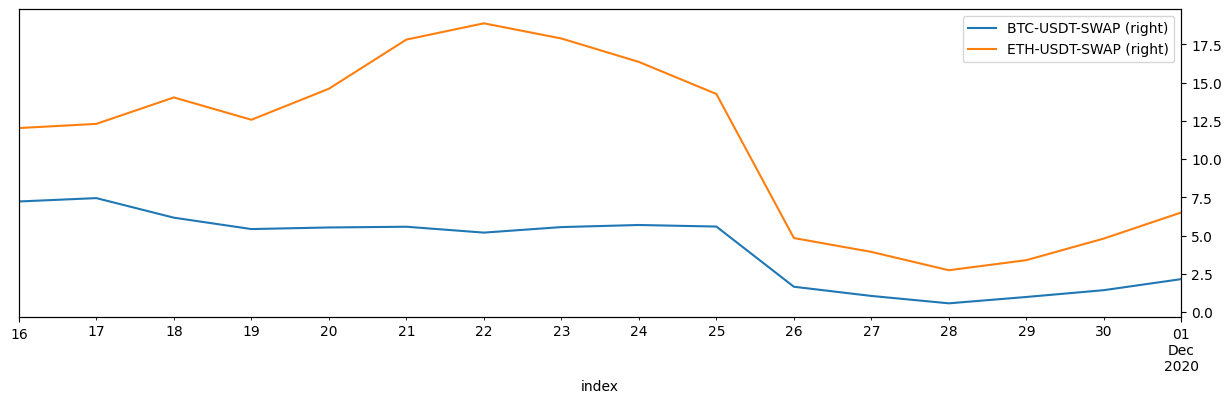

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


0.6333333333333333


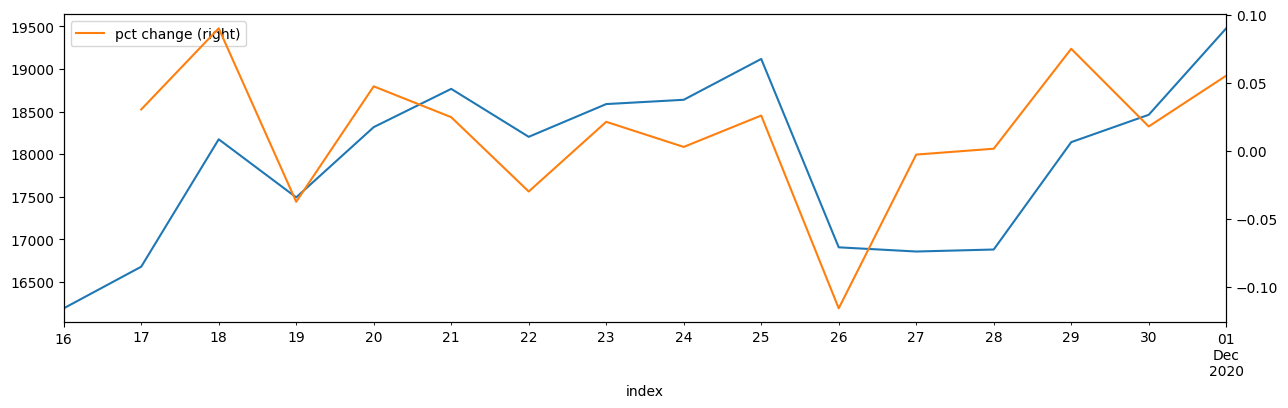

In [8]:
import pandas as pd
st = '2020-11-16'
et = '2020-12-01'

position_list = []
for ins in system.portfolio.get_instrument_list():
    if 'DOGE' in ins:
        continue
    position = system.portfolio.get_actual_position(ins).rename(ins)
    position = select(position, st, et)
    position_list.append(position)
pd.concat(position_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().rename('pct change').plot(secondary_y=True, legend=True)

print(19_000 * 5 * 0.01  / system.accounts.get_notional_capital() )

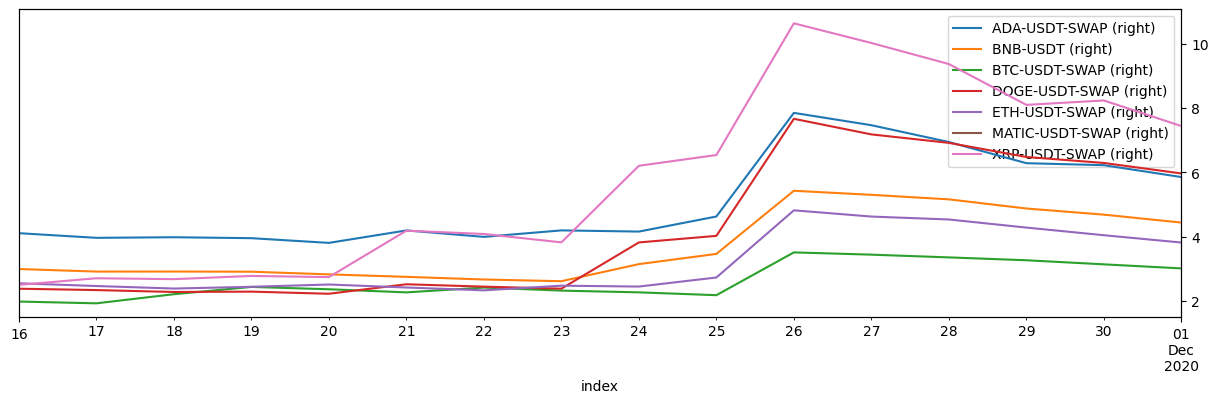

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


57.0


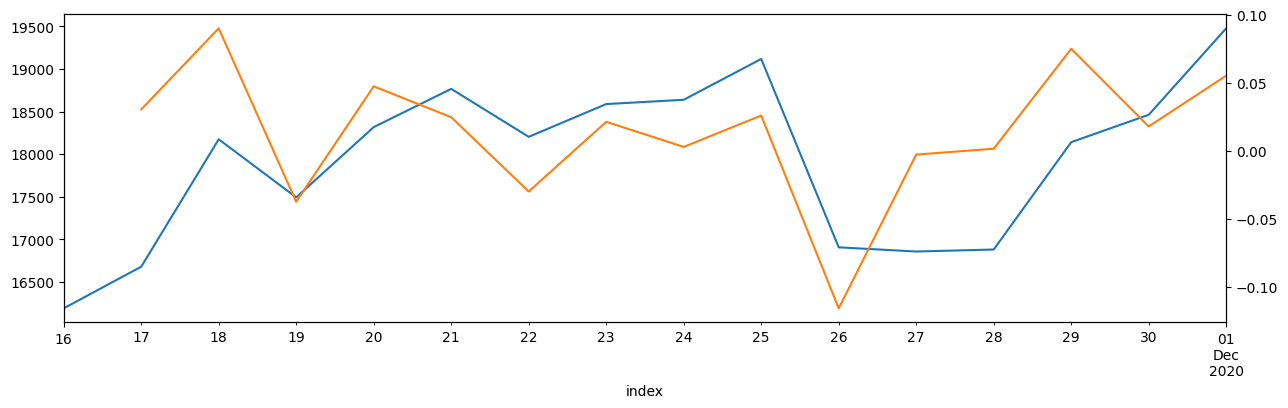

In [74]:
import pandas as pd
from syscore.dateutils import ROOT_BDAYS_INYEAR


st = '2020-11-16'
et = '2020-12-01'

tmp_list = []
for ins in system.portfolio.get_instrument_list():
    tmp = system.positionSize.get_price_volatility (ins).rename(ins)
    tmp = select(tmp, st, et)
    tmp_list.append(tmp)
pd.concat(tmp_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().plot(secondary_y=True)

print(ROOT_BDAYS_INYEAR * 3)

<AxesSubplot:>

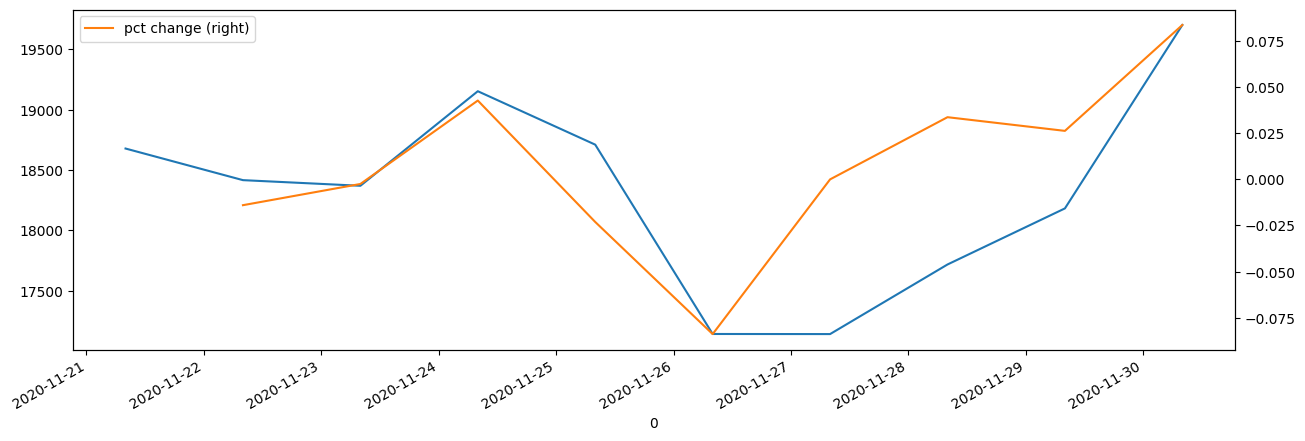

In [40]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-21T00:00+00' 
et = '2020-12-01' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1d', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().rename('pct change').plot(figsize=(15,5), secondary_y=True, legend=True)

<AxesSubplot:>

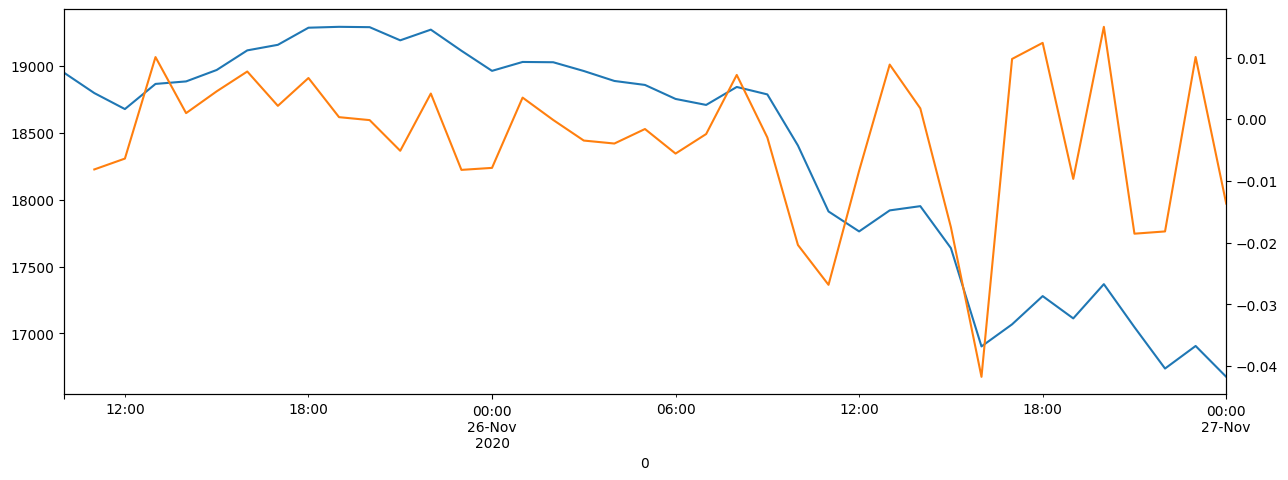

In [41]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-25T10:00+08' 
et = '2020-11-27' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1h', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().plot(figsize=(15,5), secondary_y=True)

2023-02-03 11:49:53 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating pandl for subsystem for instrument BTC-USDT-SWAP


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-03 11:49:53 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating buffers for BTC-USDT-SWAP
2023-02-03 11:49:53 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating forecast method buffers for BTC-USDT-SWAP
2023-02-03 11:49:53 {'type': 'base_system', 'stage': 'accounts'}  Calculating buffered subsystem positions
0.16666666666666666
1.5789473684210527


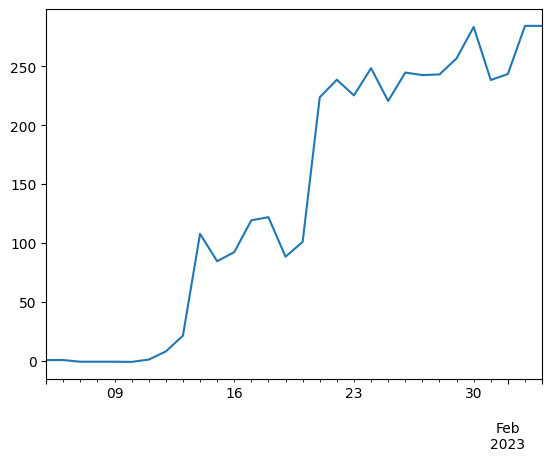

In [18]:
show(system.positionSize.get_subsystem_position('BTC-USDT-SWAP').tail(30))
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').tail(30).cumsum().plot()
print(250 / 1500)
print(30 / (361 ** 0.5))

2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating pandl for subsystem for instrument BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2023-02-02 17:52:12 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2023-02-02 17:52:12 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating subsystem position for BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating volatility scalar for BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating instrument value vol for BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating instrument currency vol for BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Retrieving natural prices for BTC-USDT-SWAP
2023-02-02 17:52:12 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily prices for BTC-USDT-SWAP
2023-02-02 17:52:13 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'B

<AxesSubplot:>

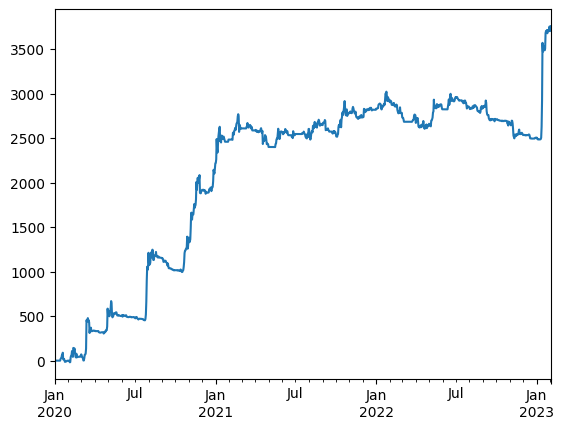

In [2]:
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').stats()
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').cumsum().plot()

2023-02-02 17:43:02 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BNB-USDT'}  Calculating normalised return for BNB-USDT
2023-02-02 17:43:02 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BNB-USDT'}  Calculating daily volatility for BNB-USDT
2023-02-02 17:43:02 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BNB-USDT'}  Calculating daily prices for BNB-USDT
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating normalised return for BTC-USDT-SWAP
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ETH-USDT-SWAP'}  Calculating normalised return for ETH-USDT-SWAP
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ETH-USDT-SWAP'}  Calculating daily volatility for ETH-USDT-SWAP
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ETH-USDT-SWAP'}  Calculating daily prices for ETH-USDT-SWAP

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating cumulative normalised return for BTC-USDT-SWAP
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'ETH-USDT-SWAP'}  Calculating cumulative normalised return for ETH-USDT-SWAP
2023-02-02 17:43:03 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BNB-USDT'}  Calculating cumulative normalised return for BNB-USDT


index
2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04          NaN
2020-01-05          NaN
                ...    
2023-01-29    55.136256
2023-01-30    55.689307
2023-01-31    54.743727
2023-02-01    54.854727
2023-02-02    56.048096
Freq: D, Name: BTC, Length: 1129, dtype: float64

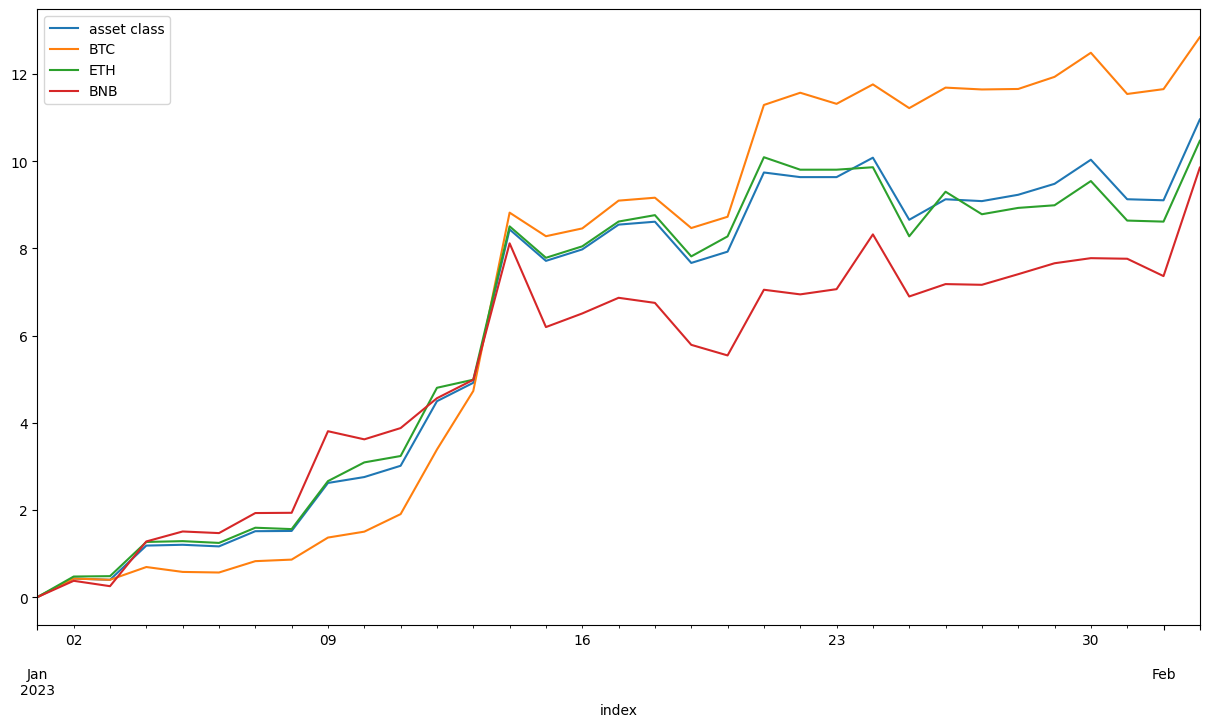

In [3]:
s1 = system.rawdata.normalised_price_for_asset_class("BTC-USDT-SWAP").rename('asset class')
s2 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BTC-USDT-SWAP").rename('BTC')
s3 = system.rawdata.get_cumulative_daily_vol_normalised_returns("ETH-USDT-SWAP").rename('ETH')
s4 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BNB-USDT").rename('BNB')
# ss = [s1, s2, s3, s4]
ss = [select(s, '2023-01-01', '2023-12-31') for s in [s1, s2, s3, s4]]
ss = [s - s.iloc[0] for s in ss]

pd.concat(ss, axis=1).plot(legend=True, figsize=(15,8))
s2
# system.rawdata.get_cumulative_daily_vol_normalised_returns("ADA-USDT-SWAP").rename('ADA').plot(legend=True)
# system.rawdata.get_cumulative_daily_vol_normalised_returns("XRP-USDT-SWAP").rename('XRP').plot(legend=True)

2023-02-02 17:38:37 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating pandl for subsystem for instrument BTC-USDT-SWAP
BTC-USDT-SWAP sharpe=1.1874026800196442 calmar=1.7277469228531188


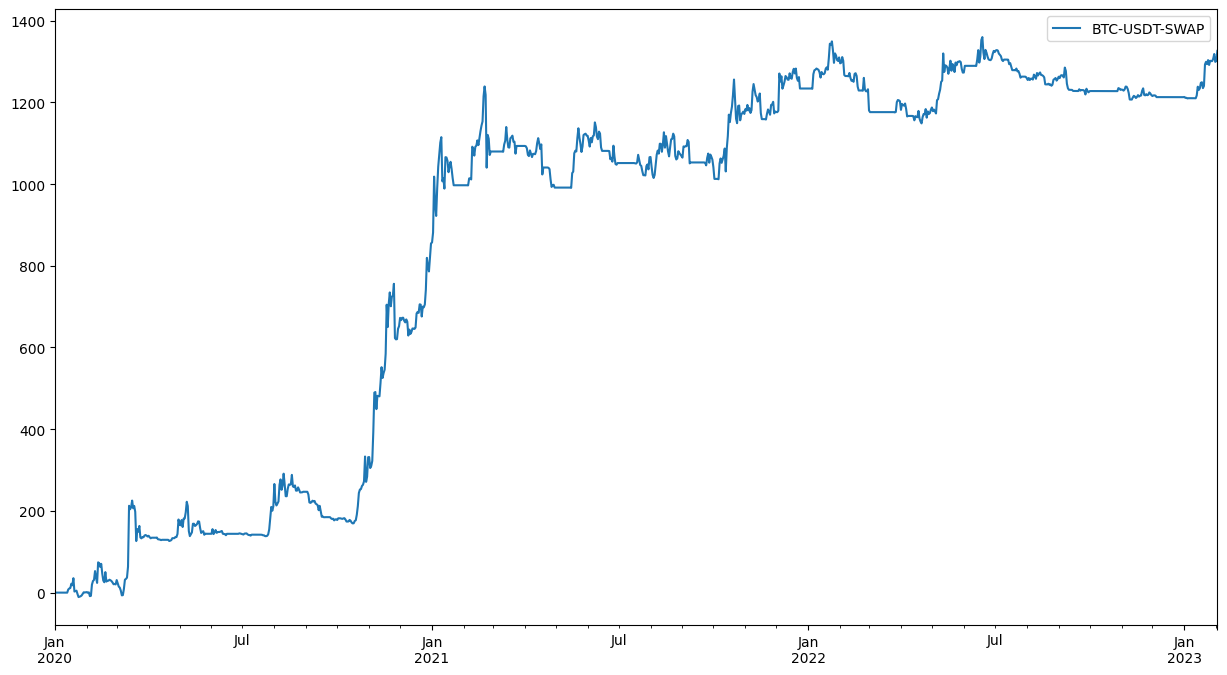

2023-02-02 17:38:37 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'ewmac4'}  Calculating pandl for instrument forecast for BTC-USDT-SWAP ewmac4
BTC-USDT-SWAP=ewmac4 sharpe=1.3302244268513064 calmar=1.5150276276810724
2023-02-02 17:38:37 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'relmomentum10'}  Calculating pandl for instrument forecast for BTC-USDT-SWAP relmomentum10
2023-02-02 17:38:37 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'relmomentum10'}  Calculating capped forecast for BTC-USDT-SWAP relmomentum10
2023-02-02 17:38:37 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'relmomentum10'}  Calculating raw forecast BTC-USDT-SWAP for relmomentum10


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


KeyError: 'relmomentum10'

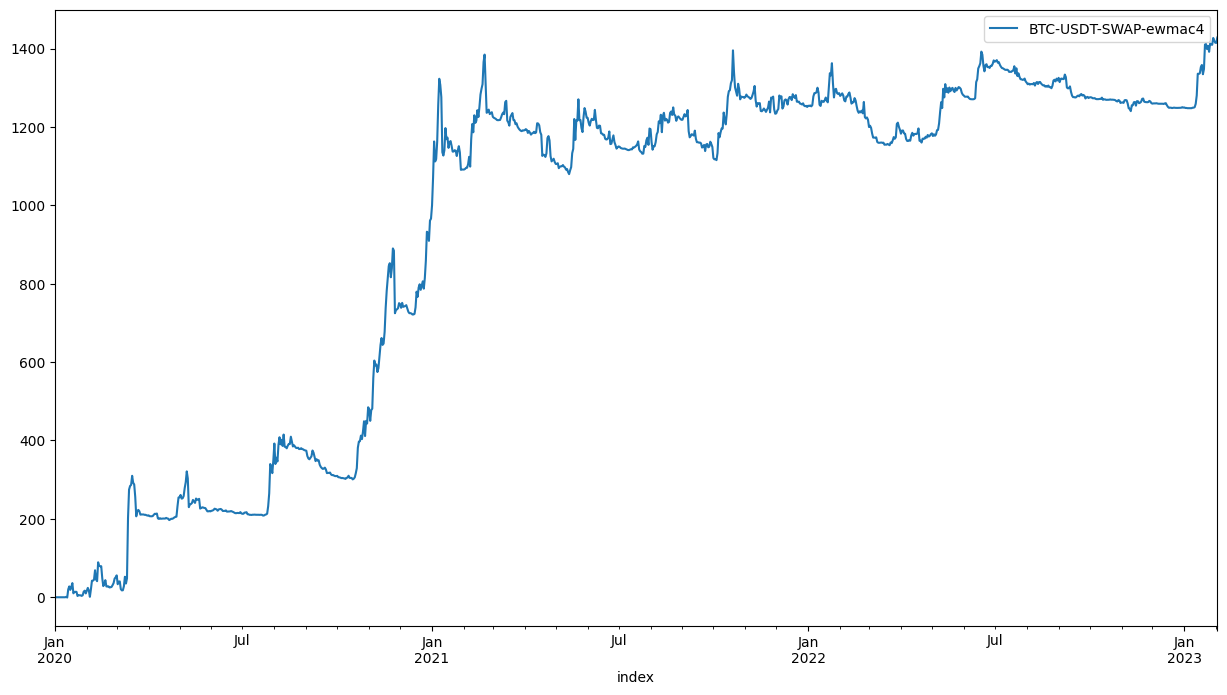

In [6]:
ins_list = ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'BNB-USDT']

'''portfolio'''
# print(system.accounts.portfolio().stats())
# system.accounts.portfolio().cumsum().rename('port').plot(legend=True, figsize=(15,8))
# plt.show()


for ins in ins_list:
    curve = system.accounts.pandl_for_subsystem(ins)
    curve.cumsum().rename(ins).plot(legend=True, figsize=(15,8))
    print('{} sharpe={} calmar={}'.format(ins, curve.sharpe(), curve.calmar()))
    plt.show()

    for rule in ['ewmac4', 'relmomentum10']:
        curve = system.accounts.pandl_for_instrument_forecast(ins, rule)
        curve.cumsum().rename('{}-{}'.format(ins, rule)).plot(legend=True, figsize=(15,8))
        print('{}={} sharpe={} calmar={}'.format(ins, rule, curve.sharpe(), curve.calmar()))
    plt.show()


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


<AxesSubplot:xlabel='index'>

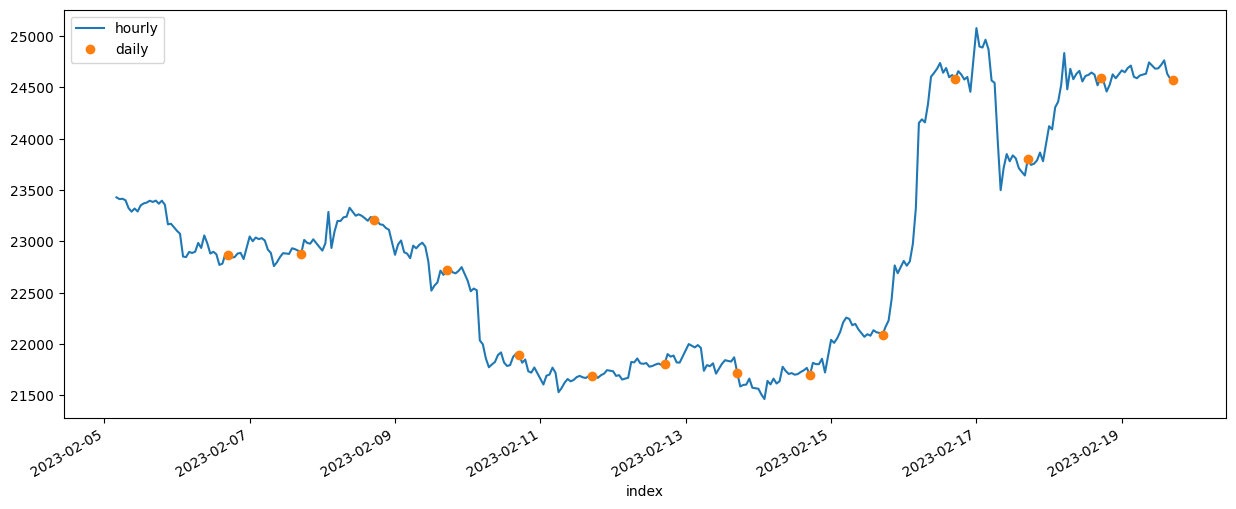

In [10]:
days = 14
daily = system.rawdata.get_daily_prices('BTC-USDT-SWAP').rename('daily').tail(days)
hourly = system.rawdata.get_hourly_prices('BTC-USDT-SWAP').rename('hourly').tail(24 * days)

hourly.plot(figsize=(15,6), legend=True)
daily.index = [date + pd.Timedelta('17h') for date in daily.index]
daily.plot(figsize=(15,6), legend=True, style='o')

In [49]:
show(daily)
show(hourly)